<a href="https://colab.research.google.com/github/minjeon99/ESAA_YB/blob/main/w9_mon_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **04. 분류**

## **09 분류 실습 - 캐글 신용카드 사기 검출**

레이블인 Class 속성은 매우 불균형한 분포 (약 0.172%만 사기 트랜잭션)
- 0: 사기가 아닌 정상적인 신용카드 트랜잭션 데이터
- 1: 신용카드 사기 트랜잭션

일반적으로 사기 검출(Fraud Detection), 이상 검출(Anomaly Detection)과 같은 데이터 세트는 레이블이 극도로 불균형한 분포를 가짐

### **언더 샘플링과 오버 샘플링의 이해**

**레이블이 불균형한 분포를 가진 데이터 세트 학습에서의 예측 성능 문제**
- 이상 레이블 데이터 건수가 정상 레이블 데이터 건수에 비해 너무 적기 때문에 발생
  - 이상 레이블: 데이터 건수가 매우 적어서 다양한 유형 학습 못함
  - 정상 레이블: 데이터 건수가 매우 많아서 일방적으로 정상 레이블로 치우친 학습 수행

  => 이상 데이터 검출이 어려움

- 지도학습에서 극도로 불균형한 레이블 값 분포로 인한 문제 해결

  : 적절한 학습 데이터 확보하는 방안이 필요
  - 오버 샘플링, 언더 샘플링 (주로 오버 샘플링 방식 사용)

  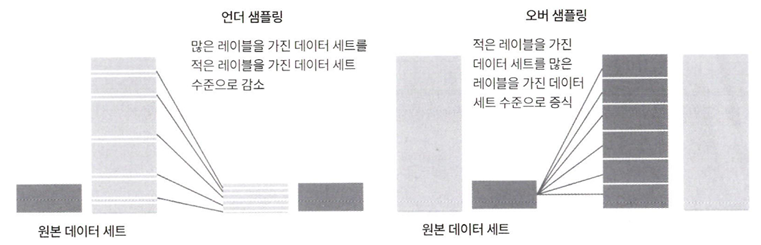
1. **언더 샘플링(Undersampling)**: 많은 데이터 세트를 적은 데이터 세트 수준으로 감소
- 과도하게 정상 레이블로 학습/예측하는 부작용을 개선
- But 오히려 정상 레이블의 경우 제대로 된 학습을 수행할 수 없다는 단점 => 잘 적용 X
2. **오버 샘플링(Oversampling)**: 적은 데이터 세트를 증식해 충분한 데이터 확보
- 동일한 데이터를 단순 증식하면 과적합이 되므로 의미 X
- 원본 데이터의 피처 값들을 약간만 변형하여 증식
- 대표적으로 **SMOTE(Synthetic Minority Over-sampling Technique)**
  - 적은 데이터 세트에 있는 개별 데이터들의 K 최근접 이웃(K Nearest Neighbor) 찾아서
  
    -> 데이터와 K개 이웃들의 차이를 일정 값으로 만들어
    
    -> 기존 데이터와 약간 차이가 나는 새로운 데이터 생성하는 방식

  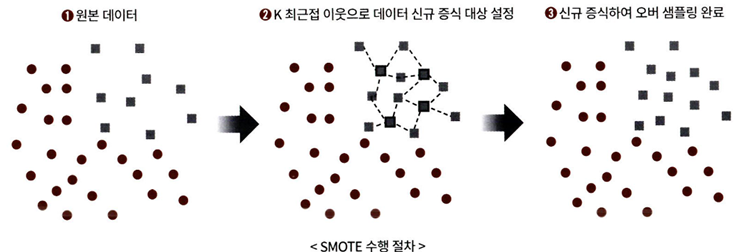

### **데이터 일차 가공 및 모델 학습/예측/평가**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('/content/drive/MyDrive/ESAA_dataset/creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


- **Time**: 의미 없는 피처이므로 제거
- **Amount**: 신용카드 트랜잭션 금액
- **Class**: 0(정상), 1(사기 트랜잭션)

In [2]:
card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

- 결측치 X
- Class만 int형, 나머지 float형

In [3]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame 복사 -> Time 칼럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  df_copy.drop('Time', axis=1, inplace=True)
  return df_copy

In [4]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트 반환하는 함수
def get_train_test_dataset(df=None):
  # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
  df_copy = get_preprocessed_df(df)
  # DataFrame의 맨 마지막 칼럼이 레이블, 나머지는 피처들
  X_features = df_copy.iloc[:,:-1]
  y_target = df_copy.iloc[:,-1]
  # train_test_split()으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
  X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
  # 학습, 테스트 데이터 세트 반환
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [5]:
# 학습/테스트 데이터 세트의 레이블 값 비율 확인
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)

학습 데이터 레이블 값 비율
Class
0    99.827451
1     0.172549
Name: count, dtype: float64
테스트 데이터 레이블 값 비율
Class
0    99.826785
1     0.173215
Name: count, dtype: float64


- 학습 데이터: 레이블 1 = 17.2%
- 테스트 데이터: 레이블 1 = 17.3%

  => 큰 차이 없이 잘 분할

#### **모델링**
- 로지스틱 회귀, LightGBM 기반 모델
- 데이터 가공 수행하며 예측 성능 변화 확인

##### **로지스틱 회귀**

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
          F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [7]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

# 3장에서 사용한 get_clf_eval() 함수 이용해 평가 수행
get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85283    12]
 [   60    88]]
정확도: 0.9992, 정밀도: 0.8800, 재현율: 0.5946,          F1: 0.7097, AUC:0.9593


- 재현율: 0.5946
- ROC-AUC: 0.9593

##### **LightGBM**

In [8]:
# 인자로 사이킷런의 Estimator 객체와 학습/테스트 데이터 세트를 입력 받아서 학습/예측/평가 수행
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
  model.fit(ftr_train, tgt_train)
  pred = model.predict(ftr_test)
  pred_proba = model.predict_proba(ftr_test)[:,1]
  get_clf_eval(tgt_test, pred, pred_proba)

`boost_from_average=False`
- 불균형한 레이블 값 분포도에서 `boost_from_average=True`는 재현율, ROC-AUC 성능을 저하시킴

In [9]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.165855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

- 재현율: 0.7588, ROC-AUC: 0.9790

  => 앞의 로지스틱 회귀보다는 높은 수치

### **데이터 분포도 변환 후 모델 학습/예측/평가**

-  대부분의 선형 모델(로지스틱 회귀)은 중요 피처들의 값이 정규 분포 형태를 유지하는 것을 선호

<Axes: xlabel='Amount', ylabel='Density'>

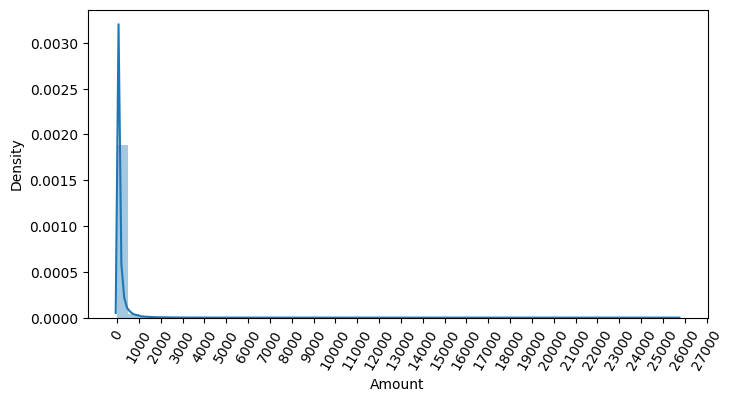

In [10]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.distplot(card_df['Amount'])

 - 1000불 이하인 데이터가 대부분
 - 27000불까지 드물지만 많은 금액을 사용한 경우가 발생하면서 꼬리가 긴 형태의 분포 곡선 가짐

  => 표준 정규 분포 형태로 변환한 뒤에 로지스틱 회귀 예측 성능 측정

#### **표준정규분포 변환**

In [11]:
from sklearn.preprocessing import StandardScaler
# 사이킷런의 StandardScaler를 이용해 정규 분포 형태로 Amount 피처값 변환하는 로직으로 수정
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  scaler = StandardScaler()
  amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
  # 변환된 Amount를 Amount_Scaled로 피처명 변경 후 DataFrame 맨 앞 칼럼으로 입력
  df_copy.insert(0,'Amount_Scaled', amount_n)
  # 기존 Time, Amount 피처 삭제
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

In [12]:
# Amount를 정규 분포 형태로 변환 후 로지스틱 회귀 및 LightGBM 수행
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,          F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

- 두 모델 모두 변환 이전과 비교해 성능이 크게 개선되지는 않음

#### **로그 변환**

- 데이터 분포도가 심하게 왜곡된 경우 적용하는 중요 기법 중 하나
- log 값으로 변환 -> 원래 큰 값을 상대적으로 작은 값으로 변환하여 데이터 분포도의 왜곡을 상당 수준 개선
- `log1p()` 이용

In [13]:
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  # 넘파이의 log1p()를 이용해 Amount를 로그 변환
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  return df_copy

`df.insert(loc, column, value, allow_duplicates=False)`
- loc : 삽입될 열의 위치
- column : 삽입될 열의 이름
- val : 삽입될 열의 값

In [14]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,          F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 344, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

- 두 모델 모두 정밀도, 재현율, ROC-AUC에서 약간씩 성능 개선되고 있음

### **이상치 데이터 제거 후 모델 학습/예측/평가**

**이상치 데이터(Outlier)**: 전체 데이터의 패턴에서 벗어난 이상 값을 가진 데이터
- 머신러닝 모델의 성능에 영향 받는 경우 발생하기 쉬움

**이상치 탐지 방법**
- **IQR(Inter Quantile Range)** = Q1(25%)~Q3(75%) 구간의 범위.  사분위 값의 편차를 이용하는 기법
- **사분위**: 전체 데이터를 값이 높은 순으로 정렬하고 1/4(25%)씩 구간 분할

  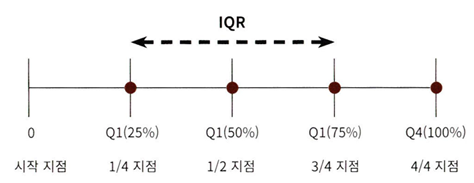
- 일반적인 데이터가 가질 수 있는 최댓값: Q3 + IQR * 1.5, 최솟값: Q1 - IQR * 1.5로 가정
- 박스 플롯 방식으로 시각화

  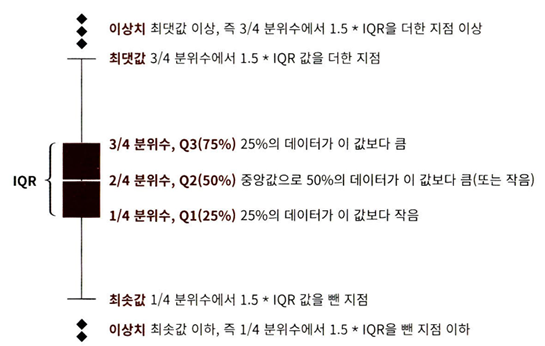

- 피처 많은 경우 -> 결정값(레이블)과 가장 상관성이 높은 피처들 위주로 이상치 검출하는 것이 좋음
  - 모든 피처의 이상치 검출은 많은 시간 소모
  - 결정값과 상관성 높지 않은 피처의 경우 이상치 제거해도 성능 향상에 크게 기여하지 X

  => `corr()`을 이용해 피처별 상관도 구한 뒤, `heatmap`으로 시각화

<Axes: >

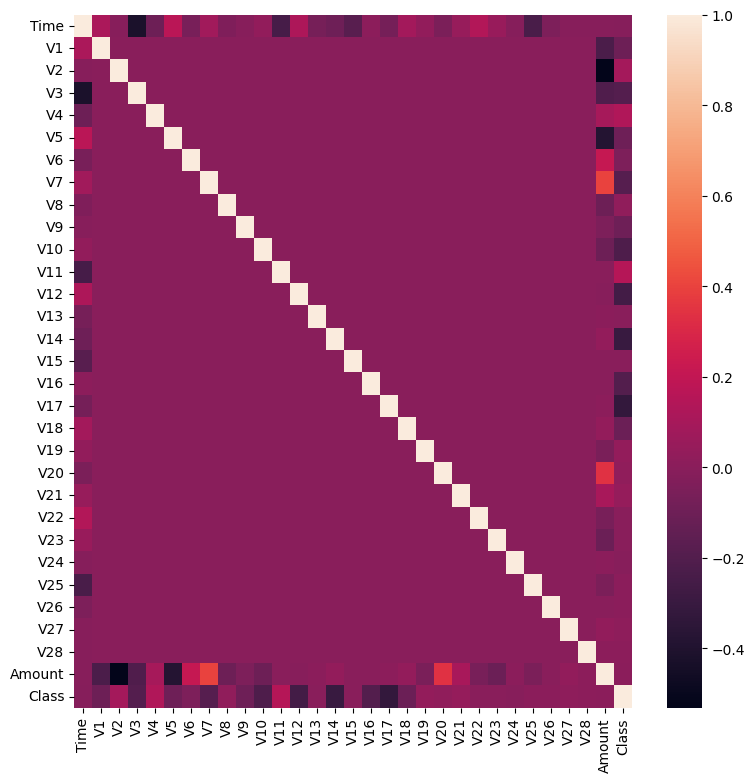

In [16]:
import seaborn as sns

plt.figure(figsize=(9,9))
corr = card_df.corr()
sns.heatmap(corr)

Class 피처와 음의 상관관계 높은 피처: V14, V17
- V14에서만 이상치 찾아 제거해보기

In [17]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
  # fraud에 해당하는 column 데이터만 추출, 1/4와 3/4분위 지점을 np.percentile로 구함
  fraud = df[df['Class']==1][column]
  quantile_25 = np.percentile(fraud.values, 25)
  quantile_75 = np.percentile(fraud.values, 75)
  # IQR 구하고 1.5 곱해 최댓값/최솟값 지점 구함
  iqr = quantile_75 - quantile_25
  iqr_weight = iqr*weight
  lowest_val = quantile_25 - iqr_weight
  highest_val = quantile_75 + iqr_weight
  # 최댓값보다 크거나 최솟값보다 작은 값 -> 이상치 데이터로 설정 -> DataFrame index 반환
  outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
  return outlier_index

In [18]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Index([8296, 8615, 9035, 9252], dtype='int64')


In [19]:
# get_processed_df(): 로그 변환 후 V14 피처의 이상치 데이터 삭제하는 로직으로 변경
def get_preprocessed_df(df=None):
  df_copy = df.copy()
  amount_n = np.log1p(df_copy['Amount'])
  df_copy.insert(0, 'Amount_Scaled', amount_n)
  df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
  # 이상치 데이터 삭제 로직 추가
  outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
  df_copy.drop(outlier_index, axis=0, inplace=True)
  return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,          F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
[LightGBM] [Info] Number of positive: 342, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 199362, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

- 두 모델 모두 예측 성능 크게 향상됨

### **SMOTE 오버 샘플링 적용 후 모델 학습/예측/평가**

- SMOTE 적용할 때는 **학습** 데이터 세트만 오버 샘플링

In [21]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트:', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트:', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포:\n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트: (199362, 29) (199362,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트: (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포:
 Class
0    199020
1    199020
Name: count, dtype: int64


- 2배에 가깝게 데이터 증식
- 레이블 0, 1 값의 분포 동일

In [23]:
lr_clf = LogisticRegression()
# ftr_train과 tgt_train 인자값이 SMOTE 증식된 X_train_over와 y_train_over로 변경됨 유의
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[82937  2358]
 [   11   135]]
정확도: 0.9723, 정밀도: 0.0542, 재현율: 0.9247,          F1: 0.1023, AUC:0.9737


- 재현율은 92.47%로 크게 향상
- 정밀도는 5.42%로 급격하게 저하
  - 적용할 수 없음
  - 실제 원본 데이터의 유형보다 너무 많은 Class=1 데이터를 학습하여 실제 테스트 데이터 세트에서 지나치게 Class=1로 예측

In [27]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
  from sklearn.metrics import precision_recall_curve
  # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
  precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

  # X축: threshold값, Y축: 정밀도/재현율 값 각각 plot. 정밀도는 점선 표시
  plt.figure(figsize=(8,6))
  threshold_boundary = thresholds.shape[0]
  plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
  plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')

  # threshold 값 X축의 Scale을 0.1 단위로 변경
  start, end = plt.xlim()
  plt.xticks(np.round(np.arange(start, end, 0.1), 2))

  # X, Y축 label/legend, grid 설정
  plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
  plt.legend(); plt.grid()
  plt.show()

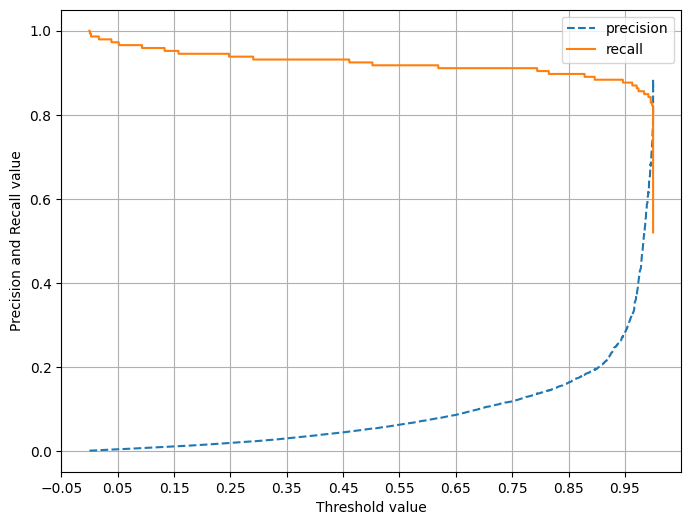

In [28]:
# 분류 결정 임곗값에 따른 정밀도/재현율 곡선을 통해 SMOTE로 학습된 회귀 모델의 문제 상황 시각화

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

- 임계값 0.99 이하: 재현율 매우 좋고, 정밀도 극단적으로 낮음
- 0.99 이상: 반대로 재현율 대폭 감소, 정밀도 높아짐
- 분류 결정 임곗값을 조정하더라도 임계값 민감도가 심해 올바른 재현율/정밀도 성능 얻을 수 없음

  => 로지스틱 회귀 모델의 경우 SMOTE 적용 후 올바른 예측 모델 생성 X

In [29]:
# LightGBM 모델에 SMOTE로 오버 샘플링 데이터로 학습/예측/평가

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.273975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

- 재현율 높아짐
- 정밀도는 낮아짐
- SMOTE를 적용하면 재현율은 높아지나, 정밀도는 낮아지는 것이 일반적
  - 재현율 증가율은 높이고 정밀도 감소율은 낮추는 것이 좋은 SMOTE

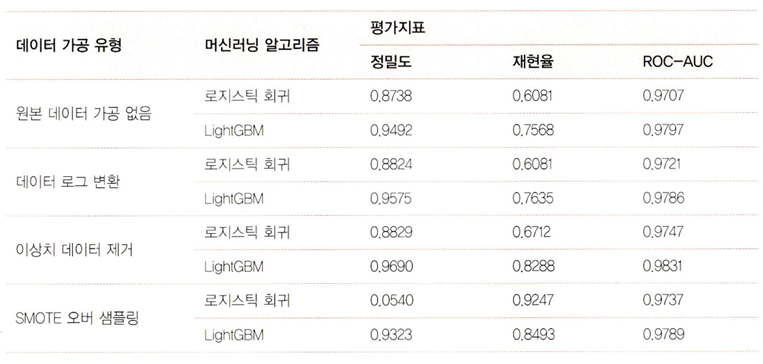

# **10. 스태킹 앙상블**

**배깅, 부스팅과의 공통점**
- 개별적인 여러 알고리즘을 결합해 예측 결과 도출

**차이점**
- 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측 수행

**스태킹 앙상블**
- 개별 알고리즘의 예측 결과 데이터 세트를 최종적인 메타 데이터 세트로 만들어 별도의 ML 알고리즘으로 최종 학습 수행 -> 테스트 데이터 기반으로 최종 예측 수행
  - **메타 모델**: 개별 모델의 예측된 데이터 세트 기반으로 다시 학습하고 예측하는 방식
- 두 종류 모델 필요 - 개별적인 기반 모델, 최종 메타 모델
- 현실에서는 많이 사용되지 않지만 캐글과 같은 대회에서 자주 사용됨
- 많은 개별 모델 필요(2~3개 이상)
- 반드시 성능 향상된다는 보장 X

  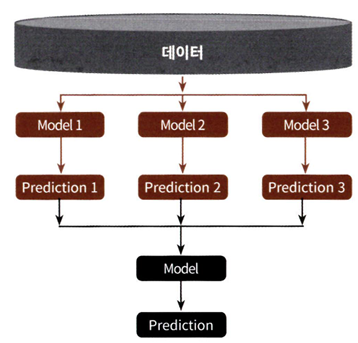

- 로우: M개, 피처(칼럼): N개
- 학습에 사용할 ML 알고리즘 모델: 3개
- 모델별로 학습시킨 뒤 예측 수행 => M개의 로우를 가진 1개의 레이블 값 도출

  -> 모델별로 도출된 예측 레이블 값을 합해서(스태킹) 새로운 데이터 세트 생성

  -> 스태킹된 데이터 세트에 대해 최종 모델 적용해 예측

  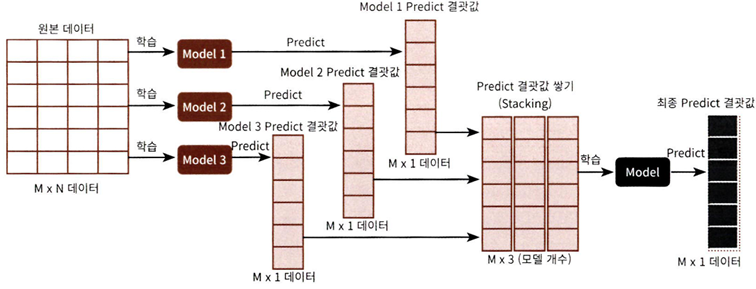

## **기본 스태킹 모델**

In [3]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2, random_state=0)

In [2]:
# 개별 ML 모델 생성
knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 스태킹으로 만들어진 데이터 세트를 학습, 예측할 최종 모델
lr_final = LogisticRegression(C=10)

In [35]:
# 개별 모델 학습
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [37]:
# 학습된 개별 모델들이 각자 반환하는 예측 데이터 세트 생성, 개별 모델 정확도 측정
knn_pred = knn_clf.predict(X_test)
rf_pred = rf_clf.predict(X_test)
dt_pred = dt_clf.predict(X_test)
ada_pred = ada_clf.predict(X_test)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_test, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
print('에이다부스트 정확도: {0:.4f}'.format(accuracy_score(y_test, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9035
에이다부스트 정확도: 0.9561


- 개별 알고리즘으로부터 예측된 예측값을 칼럼 레벨 옆으로 붙여서 피처 값으로 만들기

  -> 로지스틱 회귀에서 학습 데이터로 다시 사용
- 반환된 예측 데이터 세트는 1차원 ndarray

  => 행 형태로 붙이기 -> `np.transpose()`로 행/열 위치 바꾼 ndarray로 변환

In [38]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# traspose를 이용해 행/열 위치 교환. 칼럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 114)
(114, 4)


In [41]:
# 생성된 데이터 세트 기반으로 최종 메타 모델(로지스틱 회귀) 학습/예측/평가

lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, final)))

최종 메타 모델의 예측 정확도: 0.9737


- 개별 모델 정확도보다 향상됨 (물론 보장되지는 않음)

## **CV 세트 기반 스태킹**

- 과적합 개선을 위해 최종 메타 모델을 위한 데이터 세트 생성 시 교차 검증 기반으로 예측된 결과 데이터 세트를 이용
  - 앞 예제: 최종 학습 시 학습(X) **테스트(O)용 레이블** 데이터 세트를 기반으로 학습 => 과적합 문제 발생할 수 있음

**CV 세트 기반 스태킹**

: 개별 모델들이 각각 교차 검증으로 메타 모델을 위한 학습용 데이터 생성과 테스트용 스태킹 데이터 생성한 뒤 메타 모델이 학습/예측
1. 각 모델별 원본 학습/테스트 데이터를 예측한 결과 값을 기반으로 메타 모델을 위한 학습/테스트용 데이터 생성
2.
  - step1에서 개별 모델들이 생성한 학습용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 학습할 최종 학습용 데이터 세트 생성
  - 각 모델들이 생성한 테스트용 데이터를 모두 스태킹 형태로 합쳐서 메타 모델이 예측할 최종 테스트 데이터 세트 생성
  - 메타 모델은 최종적으로 생성된 학습 데이터 세트와 원본 학습 데이터의 레이블 데이터를 기반으로 학습
  - 최종적으로 생성된 테스트 데이터 세트 예측
  - 원본 테스트 데이터의 레이블 데이터 기반으로 평가
- 핵심은 개별 모델에서 메타 모델(2차 모델)에서 사용될 학습용 데이터와 테스트용 데이터를 교차 검증을 통해서 생성하는 것

**Step1**
- 학습용 데이터를 N(=3)개의 폴드(fold)로 나눔

  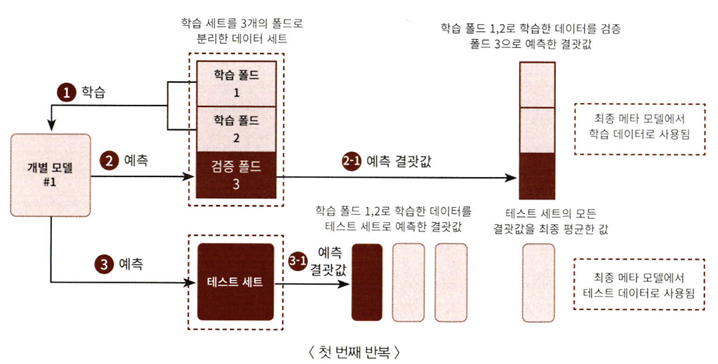
1. 학습용 데이터 3개의 폴드 중 2개는 학습을 위한 데이터 폴드, 1개는 검증을 위한 데이터 폴드

  => 2개의 폴드로 나뉜 학습 데이터를 기반으로 **개별 모델 학습**

  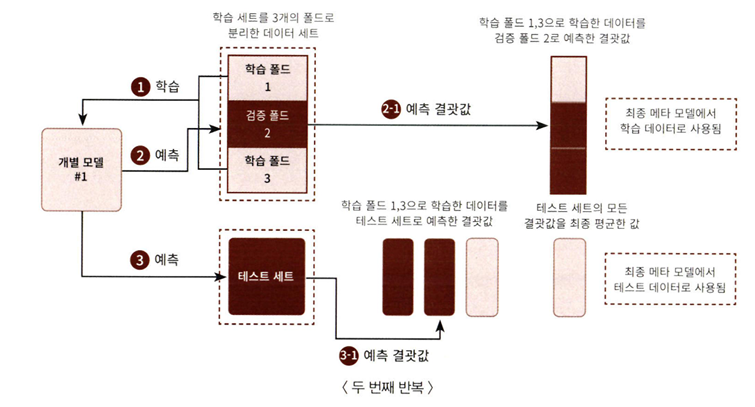
2. 학습된 개별 모델이 검증 폴드 1개 데이터로 예측 -> 결과 저장
  - 이 로직을 3번 반복 (학습/검증 데이터 세트 변경해가며 학습 -> 예측 결과 저장)

  => 만들어진 예측 데이터는 **메타 모델**을 학습시키는 **학습 데이터**로 사용

  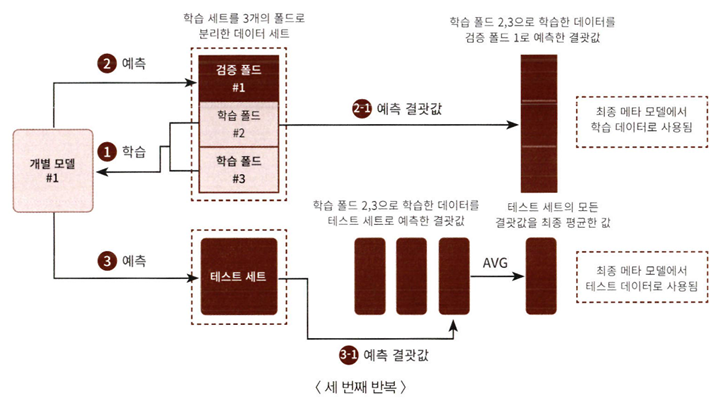
3. 2개의 학습 폴드 데이터로 학습된 개별 모델은 원본 테스트 데이터를 예측 -> 예측값 생성
  - 이 로직을 3번 반복 -> 예측값의 평균으로 최종 결괏값 생성

  => **메타 모델**을 위한 **테스트 데이터**로 사용

- 3번째 반복을 완료하면 폴드 내의 학습용 데이터 세트 변경됨
- 각 반복 수행에서 만들어진 폴드별 예측 데이터를 합하여 메타 모델에서 사용된 학습 데이터 만들게 됨
- 각 반복 수행에서 만들어진 폴드별 원본 테스트 세트 예측 결괏값을 최종 평균하여 메타 모델에서 사용될 테스트 데이터 만들게 됨

  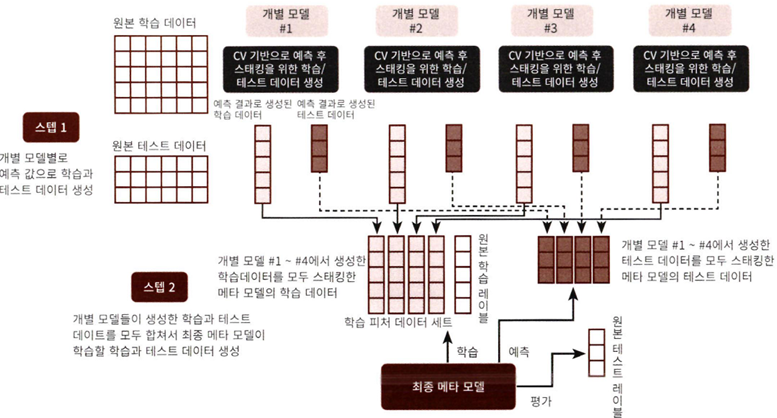

**Step 2**
- 각 모델들이 Step 1로 생성한 학습과 테스트 데이터를 모두 합쳐서 최종적으로 메타 모델이 사용할 학습 데이터와 테스트 데이터 생성

In [8]:
# Step 1
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습/테스트용 데이터 생성을 위한 함수
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
  # 지정된 n_folds 값으로 KFold 생성
  kf = KFold(n_splits=n_folds, shuffle=False)
  # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
  train_fold_pred = np.zeros((X_train_n.shape[0],1))
  test_pred = np.zeros((X_test_n.shape[0], n_folds))
  print(model.__class__.__name__, 'model 시작')

  for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
    # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
    print('\t 폴드 세트: ', folder_counter, '시작')
    X_tr = X_train[train_index]
    y_tr = y_train[train_index]
    X_te = X_train[valid_index]

    # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행
    model.fit(X_tr, y_tr)
    # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장
    train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
    # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장
    test_pred[:, folder_counter] = model.predict(X_test_n)

  # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
  test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

  # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
  return train_fold_pred, test_pred_mean

In [10]:
knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train, y_train, X_test, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train, y_train, X_test, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train, y_train, X_test, 7)
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train, y_train, X_test, 7)

KNeighborsClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
RandomForestClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
DecisionTreeClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작
AdaBoostClassifier model 시작
	 폴드 세트:  0 시작
	 폴드 세트:  1 시작
	 폴드 세트:  2 시작
	 폴드 세트:  3 시작
	 폴드 세트:  4 시작
	 폴드 세트:  5 시작
	 폴드 세트:  6 시작


In [12]:
# Step 2
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:', X_train.shape, '원본 테스트 피처 Shape:', X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:', Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (455, 30) 원본 테스트 피처 Shape: (114, 30)
스태킹 학습 피처 데이터 Shape: (455, 4) 스태킹 테스트 피처 데이터 Shape: (114, 4)


스태킹 학습 피처 데이터
- Row 크기: 원본 학습 피처 데이터와 동일
- Column 크기: 4개의 개별 모델 예측값 합침 => 4

In [14]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))

최종 메타 모델의 예측 정확도: 0.9737
